In [1]:
import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module='PIL.Image')

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import initializers

# Data preprocessing

# image preprocessing

In [3]:
# Data Generators
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    r"C:\Users\USER\Documents\Training",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    r"C:\Users\USER\Documents\Validation",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


# Building the model architecture

In [4]:
def create_model(input_shape=(224, 224, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)

    # First block - Increased filters and added layers
    block1 = Sequential([
        layers.Conv2D(96, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(96, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2)
    ])
    
    # Second block - Deeper with more filters
    block2 = Sequential([
        layers.Conv2D(192, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(192, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2)
    ])
    
    # Third block 
    block3 = Sequential([
        layers.Conv2D(384, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(384, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(2)
    ])
    
    # Apply blocks
    x = block1(inputs)
    block1_output = x  # Save for skip connection
    x = block2(x)
    block2_output = x  # Save for second skip connection
    x = block3(x)
    
    # Enhanced attention mechanism
    channel_attention = Sequential([
        layers.GlobalAveragePooling2D(),
        layers.Dense(384 // 16, activation='relu'),
        layers.Dense(384, activation='sigmoid'),
        layers.Reshape((1, 1, 384))
    ])(x)
    
    spatial_attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(x)
    
    x = layers.Multiply()([x, channel_attention])
    x = layers.Multiply()([x, spatial_attention])
    
    # Multiple skip connections
    # First skip connection
    block1_output = layers.Conv2D(384, 1, kernel_regularizer=l2(0.01))(block1_output)
    block1_output = layers.MaxPooling2D(4)(block1_output)  # Match spatial dimensions
    
    # Second skip connection
    block2_output = layers.Conv2D(384, 1, kernel_regularizer=l2(0.01))(block2_output)
    block2_output = layers.MaxPooling2D(2)(block2_output)  # Match spatial dimensions
    
    x = layers.Add()([x, block1_output, block2_output])
    
    # Enhanced multi-scale processing
    # Scale 1: Original scale
    scale1 = Sequential([
        layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu')
    ])(x)
    
    # Scale 2: Reduced scale
    scale2 = Sequential([
        layers.AveragePooling2D(2),
        layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.UpSampling2D(2)
    ])(x)
    
    # Scale 3: Further reduced scale
    scale3 = Sequential([
        layers.AveragePooling2D(4),
        layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.01)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.UpSampling2D(4)
    ])(x)
    
    # Combine scales with attention
    merged = layers.Concatenate()([scale1, scale2, scale3])
    
    # Enhanced final processing
    x = layers.Conv2D(512, 1, activation='relu', kernel_regularizer=l2(0.01))(merged)
    x = layers.Conv2D(512, 1, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Wider fully connected layers
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=outputs)

model = create_model()

In [5]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 112, 112, 96  86496       ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 56, 56, 192)  499584      ['sequential[0][0]']             
                                                                                              

In [7]:
# Define learning rate reduction
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=30,
    callbacks=[reduce_lr]
)

Epoch 1/30
178/178 [==============================] - 3118s 17s/step - loss: 26.3597 - accuracy: 0.5866 - val_loss: 10.9139 - val_accuracy: 0.2320 - lr: 0.0010
Epoch 2/30
 18/178 [==>...........................] - ETA: 43:25 - loss: 8.9234 - accuracy: 0.6146

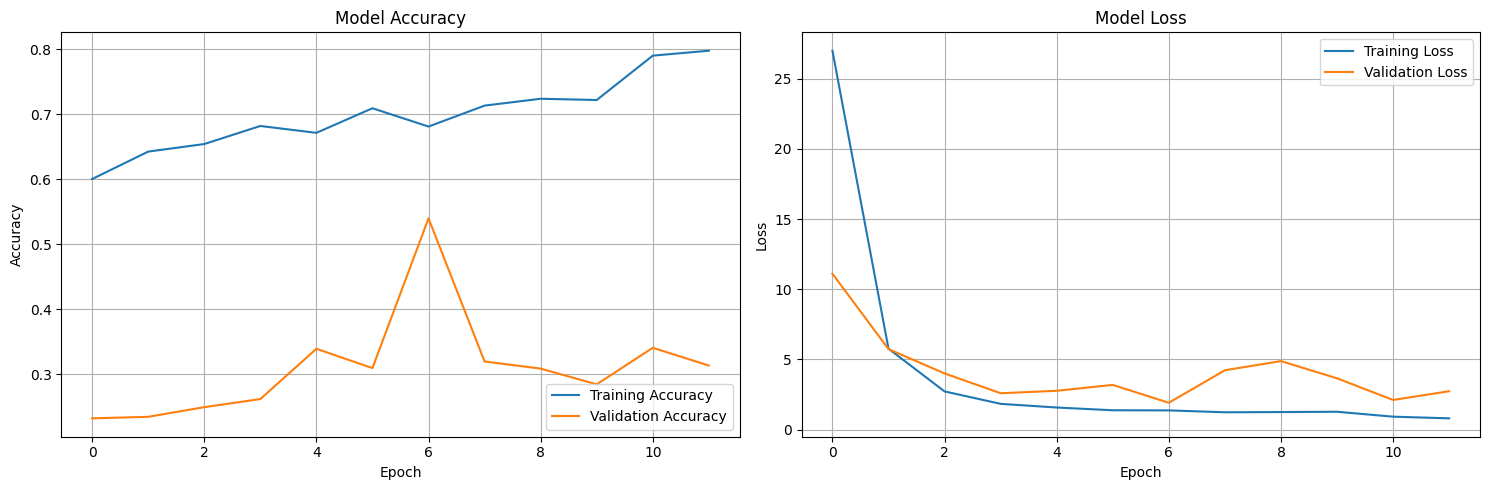


Final learning rate: 0.00020000000949949026

Best epoch: 7
Best validation loss: 1.9086
Best validation accuracy: 0.5398


In [11]:
# Plot training history
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# Print final learning rate
final_lr = tf.keras.backend.get_value(model.optimizer.lr)
print(f"\nFinal learning rate: {final_lr}")

# Print best epoch's metrics
best_epoch = np.argmin(history.history['loss','val_loss']) + 1
print(f"\nBest epoch: {best_epoch}")
print(f"Best training and validation loss: {min(history.history['loss','val_loss']):.4f}")
print(f"Best training and validation accuracy: {max(history.history['accuracy','val_accuracy']):.4f}")

In [12]:
from tensorflow.keras.models import load_model

model = load_model('tumor_model.h5',custom_objects={'CustomAttention': CustomAttention})
print("Best model loaded successfully.")

Best model loaded successfully.


In [13]:
# Evaluate the model on test data
test_generator = test_datagen.flow_from_directory(
    r"C:\Users\USER\Documents\Testing",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [ ]:
# Predict on the test data
true_labels = test_generator.classes
predicted_labels = model.predict(test_generator)
predicted_labels = np.argmax(predicted_labels, axis=1)
print(predicted_labels)

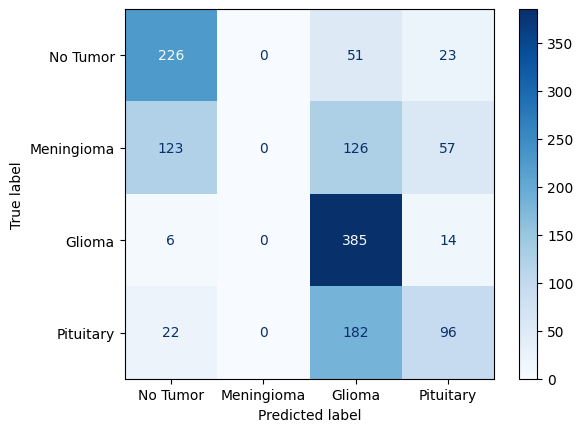

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Tumor', 'Meningioma', 'Glioma', 'Pituitary'])
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Visualize the loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['Test_loss'], label='Test_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

37/41 [==========================>...] - ETA: 18s - loss: 1.9300 - accuracy: 0.5515

In [ ]:
# Get a batch of images and labels
images, labels = next(test_generator)

# Number of images to display
num_images = 36

num_images = min(num_images, images.shape[0])

# Get random indices for sampling
indices = np.random.choice(images.shape[0], num_images, replace=False)

# Plot images
plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    plt.subplot(6, 6, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Class: {np.argmax(labels[idx])}")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Test Images")
plt.show()

In [ ]:
print("Images shape:", images.shape)

In [ ]:
print(type(images))  # <class 'numpy.ndarray'>
print(images.shape)  

print(type(labels))  # <class 'numpy.ndarray'>
print(labels.shape) 

In [ ]:
# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    img_array /= 255.0  # Normalize if needed (match training preprocessing)
    return img_array

# Load and preprocess a single image
img_path = r"C:\Users\USER\Desktop\IMG_TEST\Apple___Apple_scab\0a5e9323-dbad-432d-ac58-d291718345d9___FREC_Scab 3417.JPG"
img_array = load_and_preprocess_image(img_path, target_size=(128, 128))  
# Make a prediction
prediction = model.predict(img_array)
predicted_class_index = np.argmax(prediction)

In [ ]:
result_index = np.where(prediction[0]==max(prediction[0]))

In [ ]:
print(result_index)

In [ ]:
plt.imshow(img)

In [ ]:
# Get class names
class_indices = test_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

#print("Class Indices:", class_indices)
print("Class Names:", class_names)

In [ ]:
print(class_names)

In [ ]:
#singe prediction
print("it's a {}".format(class_names[result_index[0][0]]))